In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pymc as pm

plt.style.use('intuitivebayes.mplstyle')
figsize = (24, 12)

In [4]:
import pymc.sampling_jax

/home/canyon/miniconda3/envs/intuitive_bayes_gp/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/canyon/miniconda3/envs/intuitive_bayes_gp/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [5]:
data = pd.read_csv("data/co2_mm_mlo.csv", header=51)

## Weighted averages

This will be useful later, but we can equivalently think of our model as using a weighted average for the estimates.  In this last case where we chose 2 neighbors, those two neighbors each get a weight of 50%, or 0.5, and all the other data points get weights of zero.  

#  Similarity Functions
Weighting the data

In the last section we started to think about modeling functions in a slightly different way.  We've freed ourselves from trying to come up with specific functional forms, but using the average of the y values of our nearest neighbor data points gives us a result that looks the most Mondrian of all!  In this section we'll keep going down the road to Jackson Pollacks stochastic processes.  Along the way, we'll build from the ground up a concept, aptly called a **kernel** that is at the core of many many machine learning algorithms, including Gaussian processes.  

## Location, location

<center>
     <img src="img/Farmhouse.png"  />
</center>

We've seen that is hard to come up with a heuristic to pick the right number of neighboring data points.  And, when we do this, our models produce results that are jumpy, Mondrian, and probably not very realistic.  Let's take one step further and reframe things in terms of **distance**.  What if all your neighbors are very far apart? 


## Location,
## Location


<center>
     <img src="img/Stackedhouse.png"  />
</center>

Or, what if they're all stacked on top of each other?

The number of neighbors that matter is clearly context dependent.  The underlying thing that's really determining change is distance, or equivalently, similarity. 

If you were standing on the porch of the farmhouse in the last slide, how far would you have to walk until you stop seeing farmhouses and start seeing the suburbs and then, the cityscape in picture 2? 


## Similarity, aka, the Kernel



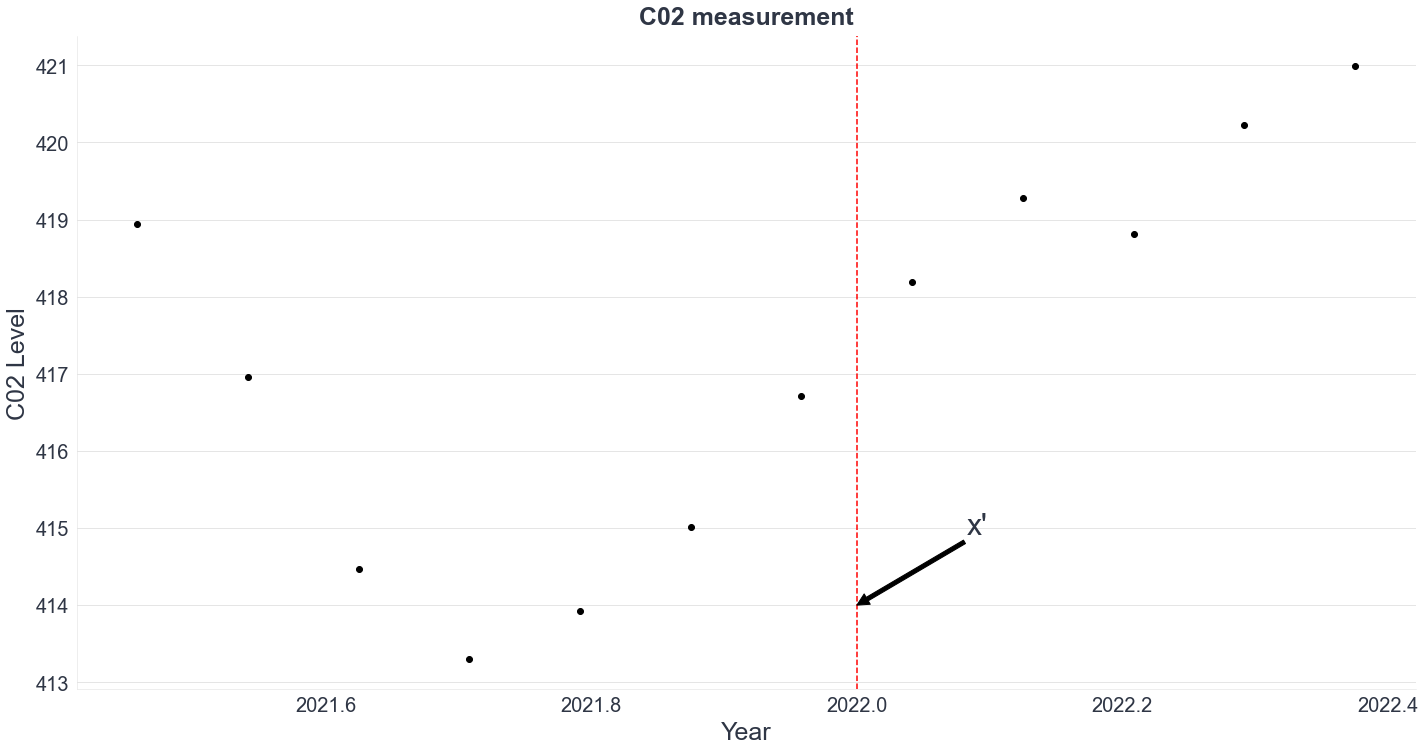

In [6]:
last_12_obs = data.sort_values("decimal date").tail(12)

fig = plt.figure(figsize=figsize)
ax = fig.gca()

def plot_data(ax):
    ax.plot(last_12_obs["decimal date"], last_12_obs["average"], "ko", label="Observed")
    ax.set_title("C02 measurement")
    ax.set_xlabel("Year")
    ax.set_ylabel("C02 Level");
    return ax

plot_data(ax);
plt.axvline(x=2022.0, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

Let's go back to Mauna Loa and apply this concept to refine the nearest neighbor idea from the previous section.  We can actually start here and use our intuition to design a simple *kernel* function from the ground up.

Distance, or similarity, in the CO2 data set isn't about walking or driving distance.  Instead, it's about time, which weve already called the x-axis.  Let's pull up our data, and like we did before, let's start at Jan 1, 2022.  But this time let's also introduce a bit of notation.  Let's call this point $x'$, so $x' = 2022.0$.  We put a vertical red line here on the plot.  Just to be sure, let's also make sure our terms are straight.  **Kernel = Similarity**, and distance is like, the opposite of similarity. 

## Distance

$$ 
\Huge
{d = ( x - x' )^2}
$$

Now let's define a distance, which we'll call $d$.  The distance we care about is the difference from our "test point" x', to anywhere else on the x axis.  Let's also make it a positive number (does negative distance mean here?) by squaring it, 

Yes, we could have also used the absolute value here to make it positive.  EXERCISE:  Try running the rest of the code using absolute value here instead of squaring.  

## Calculating the distance our two favorite points

** Insert plot from section 30 where nearest neighors are highlighted**

Notice how the distance calculation between the two points here. The difference in the final value means were weighting one of the points more than the other. Also note how even though the calculation within the parans is negative, when we square it it turns positive. 

## Plotting the distance to *every* x

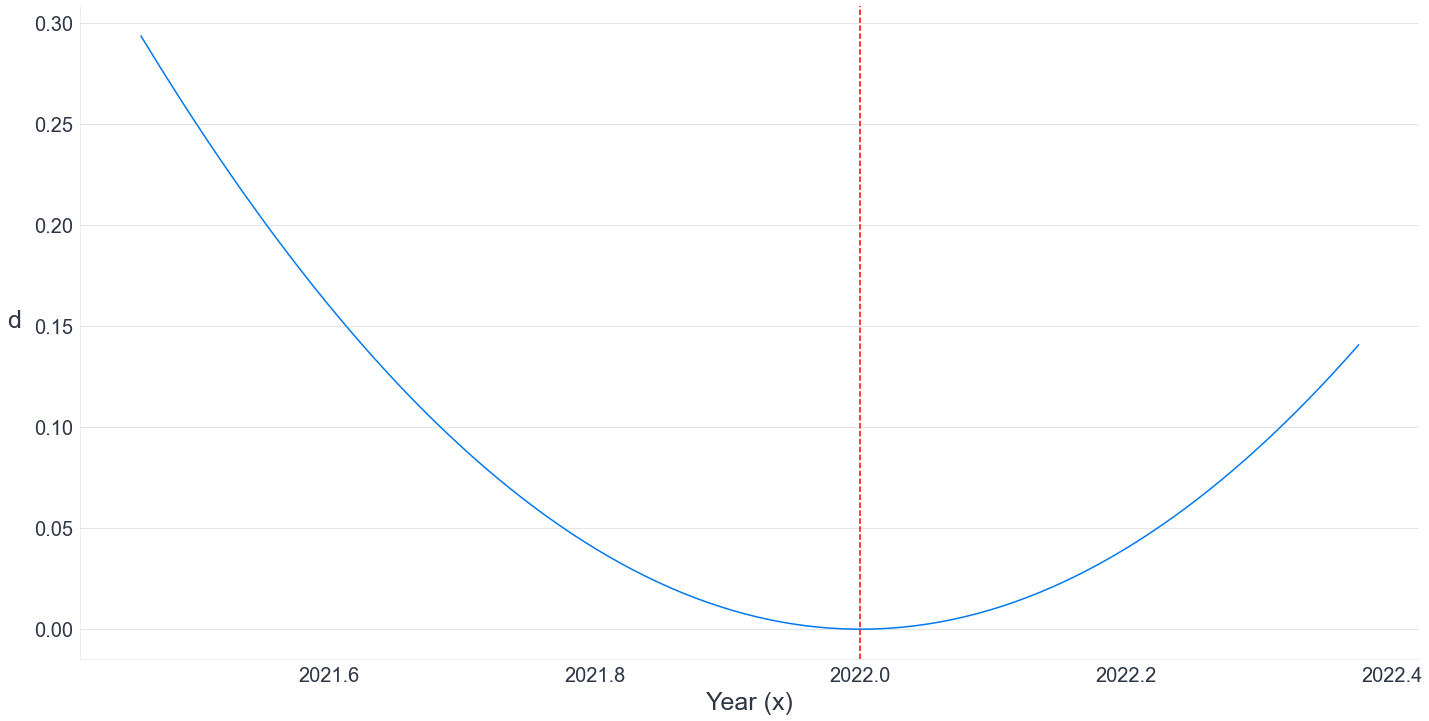

In [18]:
fig = plt.figure(figsize=figsize)

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 100)
x_prime = 2022.0

plt.plot(x, np.square(x - x_prime));

plt.axvline(x=2022.0, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

plt.ylabel("d", rotation=0, labelpad=20);
plt.xlabel("Year (x)");

To help build our intuition, this is a plot of $d$ as a function of $x$, where $x' = 2022.0$.  You can see that as we get further and further away from our test point $x'$, the distance increases.  That's kind of obvious right?  But also think about the *way* the distance increases. 

And just to plant the seed so you start thinking about it, when we're making modeling choices now, we are thinking about things like, how does our data change with distance?  Choices about whether we square, or absolute value, or as we'll see later, use other types of measures entirely will be the crux the model. There isn't a "right" distance to use, that's determined by the data and you.  

## How far is far?


$$
\begin{align}
d &= \left( \frac{x}{\ell} - \frac{x'}{\ell} \right)^2 \\
  &= \left( \frac{x - x'}{\ell} \right)^2 \\
  &= \frac{(x - x')^2}{\ell^2}  \\
\end{align}
$$


In that spirit, we introduce a very important parameter $\ell$, called the *lengthscale*.  As we'll see later, the idea of a lengthscale is very common in GP modeling -- we'll be talking about it a lot in the future.  It's used to scale the distance, and it answers the question of, what exactly counts as close, and what exactly counts as far?  It's role is to sort of standardize the distances by scaling each $x$, and $x'$,




## Most common form

$$
\huge
\begin{align}
d &= \frac{(x - x')^2}{\ell^2}  \\
\end{align}
$$

The last one is usually how it's written. We want to show it to you because you'll often see it in literature and we 'd like you to be prepared.

We're done with the mathematical definition of distance function now!

## The effect of the length scale parameter

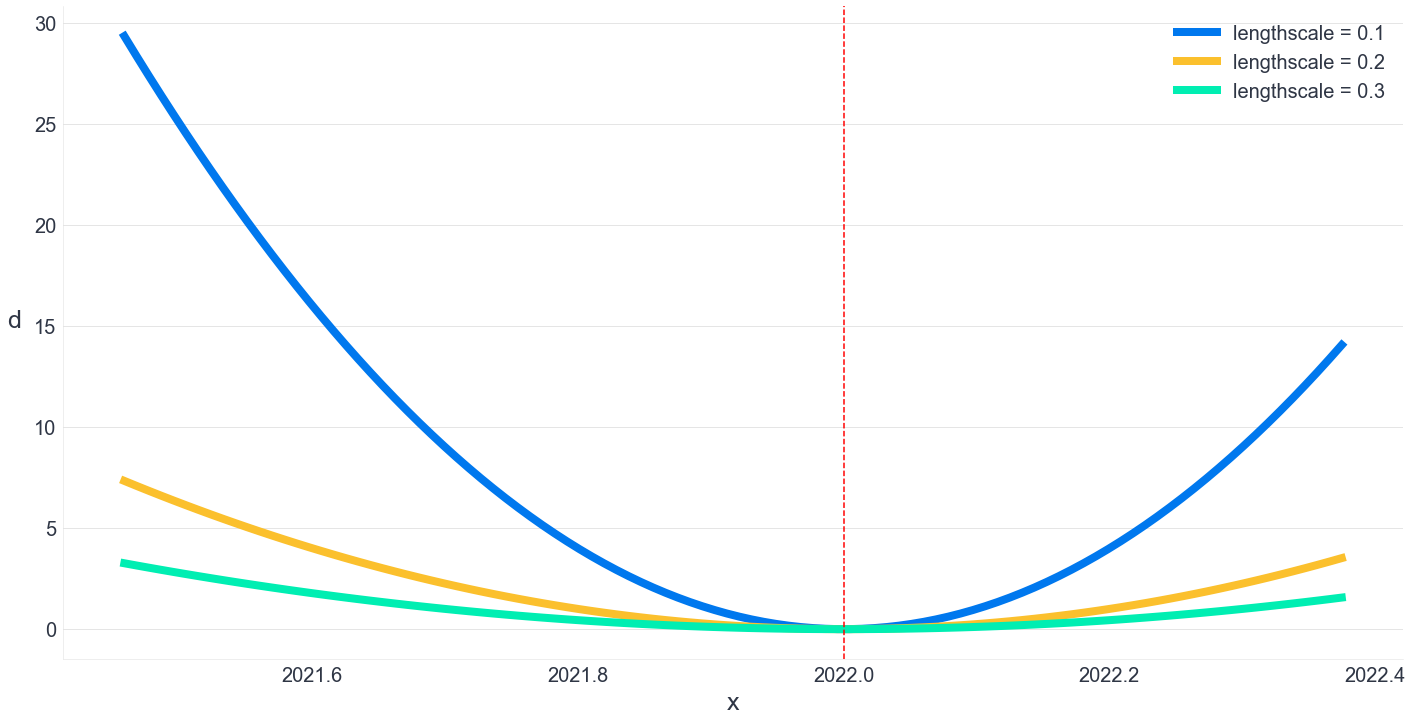

In [29]:
fig = plt.figure(figsize=figsize)

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 100)
x_prime = 2022.0

lengthscales = [0.1, 0.2, 0.3]

for ell in lengthscales:
    plt.plot(x, np.square((x - x_prime) / ell), label=f"lengthscale = {ell}", lw=8);

plt.axvline(x=x_prime, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);
plt.ylabel("d", rotation=0, labelpad=20)
plt.xlabel("x");
plt.legend(fontsize=20);

Let's play with what we have in code.  Let's remake the previous plot, but try a few different lengthscales (for you sticklers out there, you could've said that we already had a lengthscale, just that it was equal to one).  

By scaling $x$ with $\ell$, we're changing what counts as "far".  Keep in mind that this is all relative to x.

* When $\ell$ is large, like 0.3 here, the distance increases slowly, it's almost flat.  It means we think of points to the far left or far right of $x'$ as not really being that far away.  You've got to go pretty far, relatively, to make the distance $d$ large. 
* When $\ell$ is small, like 0.1 here, the distance increases rapidly.  It doesn't take much distance, to get far away.  

## Short Length Scale: Walking from LA to New York 

<center>
     <img src="img/LatoNYWalk.png"/>
</center>

The length scale is like your mode of transportation.  It's very, very far from New York to LA.  Google says it would take 918 hours to walk there.  That's like a short length scale -- small steps.  Looking at a map of America, everything is far if you're walking.  

## Medium Length Scale: Walking from LA to New York 

<center>
     <img src="img/LaToNYDrive.png"/>
</center>


If you drive however, Google says it would take 41 hours.  Better! 


## Long Length Scale: Flying from LA to New York 

<center>
     <img src="img/LatoNYFly.png"/>
</center>


Flying is like a long lengthscale.  For that one Google says 5 hours and 35 minutes.  Whether you're flying to LA, or Florida, or Chicago, it's all about the same more or less -- a few hours.  You wouldn't say that if you were walking! 

## Similarity
$$ \large
k(x, x'\,; \ell) = \exp \left[  \frac{(x - x')^2}{\ell^2} \right]
$$


Also known as RBF (radial basis function) or **exponentiated quadratic** kernel.  



How can we use our new distance function to scale the data?  There are a couple small steps we still need to take.  First, our distance function goes from $\infty$ (far) to zero (close).  For this (and so many other ML algorithms!) we want things in terms of similarity instead of distance.  We're going to call our similarity function $k$ for kernel.  It's mainly function of $x$, but if you think about it, $x'$ too.  Also, the lengthscale is a parameter in there too.  It's a bit different than $x$ and $x'$ or course, so we'll separate it a bit for readability. 

Remember, we need our data points that are close together to have a higher weight, or similarity, than those that are far apart.  One way to accomplish this is to exponentiate $d$, and stick a minus sign up in there.  





## Almost Gaussian, but not that Gaussian



$$ \large
k(x, x'\,; \ell) = \exp \left[  \frac{(x - x')^2}{\ell^2} \right]
$$


You might recognize this as *almost* a normal, or Gaussian distribution.  It's a coincidence.  This is NOT where the name "Gaussian" in Gaussian process comes from.  We'll see where it comes from in the next lesson.  We'll see in upcoming lessons that there are **many** different similarity functions you could make.  It's actually fairly common to change this one to use absolute value instead of squaring the distance.

## Weighting function

In [9]:
# Quadratic Kernel in code
x_prime = 2022.0

def kernel(x, x_prime, lengthscale):
    return np.exp( -1.0 * np.square(x - x_prime) / np.square(lengthscale))

x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)
weights = kernel(x, x_prime, 0.1)

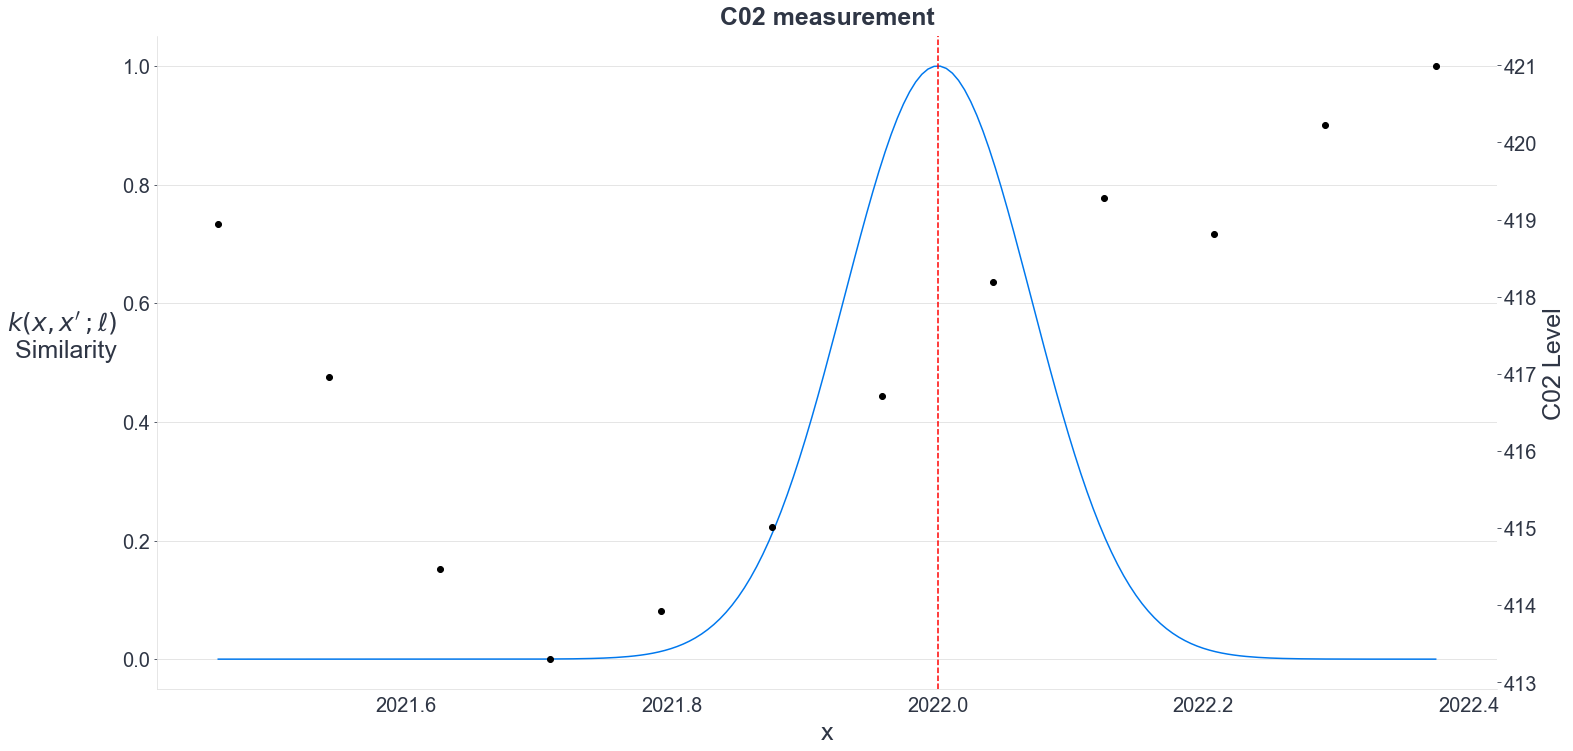

In [25]:
fig = plt.figure(figsize=figsize)


plt.plot(x, weights,label=f"lengthscale = {ell}");

plt.axvline(x=2022.0, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);

plt.ylabel("$k(x, x'\,; \ell)$\n Similarity", rotation=0, loc="center", labelpad= 60);
plt.xlabel("x");


ax = plt.gca()
ax2 = ax.twinx()
ax2 = plot_data(ax2)
ax2.grid(False);

Let's make the same kinds of plots we did with distance, except using the kernel function.  Also, we'll overlay our data, so we can see the similarities assigned to the points near $x'$.   

## Building the kernel machine

In [11]:
def kernel_machine(x, y, x_prime, lengthscale):
    k = kernel(x, x_prime, lengthscale)
    w = k / np.sum(k)
    estimate = np.dot(w, y)
    return estimate

Now the last step.  Let's make a super simple kernel regression machine.  Let's use our kernel to calculate weights for each data point, then, we'll normalize them so that they all sum to 1.  Our estimator at $x'$, will be given by this weighted average.  We'll make the same plot, but show the estimate our kernel machine gives.  The kernel machine's estimate is the weighted sum of the datapoints under the "umbrella" of the kernel function.

## Using our machine to make an estimate 

In [ ]:
x_prime = 2022.0
lengthscale = 0.1
x = np.linspace(last_12_obs["decimal date"].min(), last_12_obs["decimal date"].max(), 200)

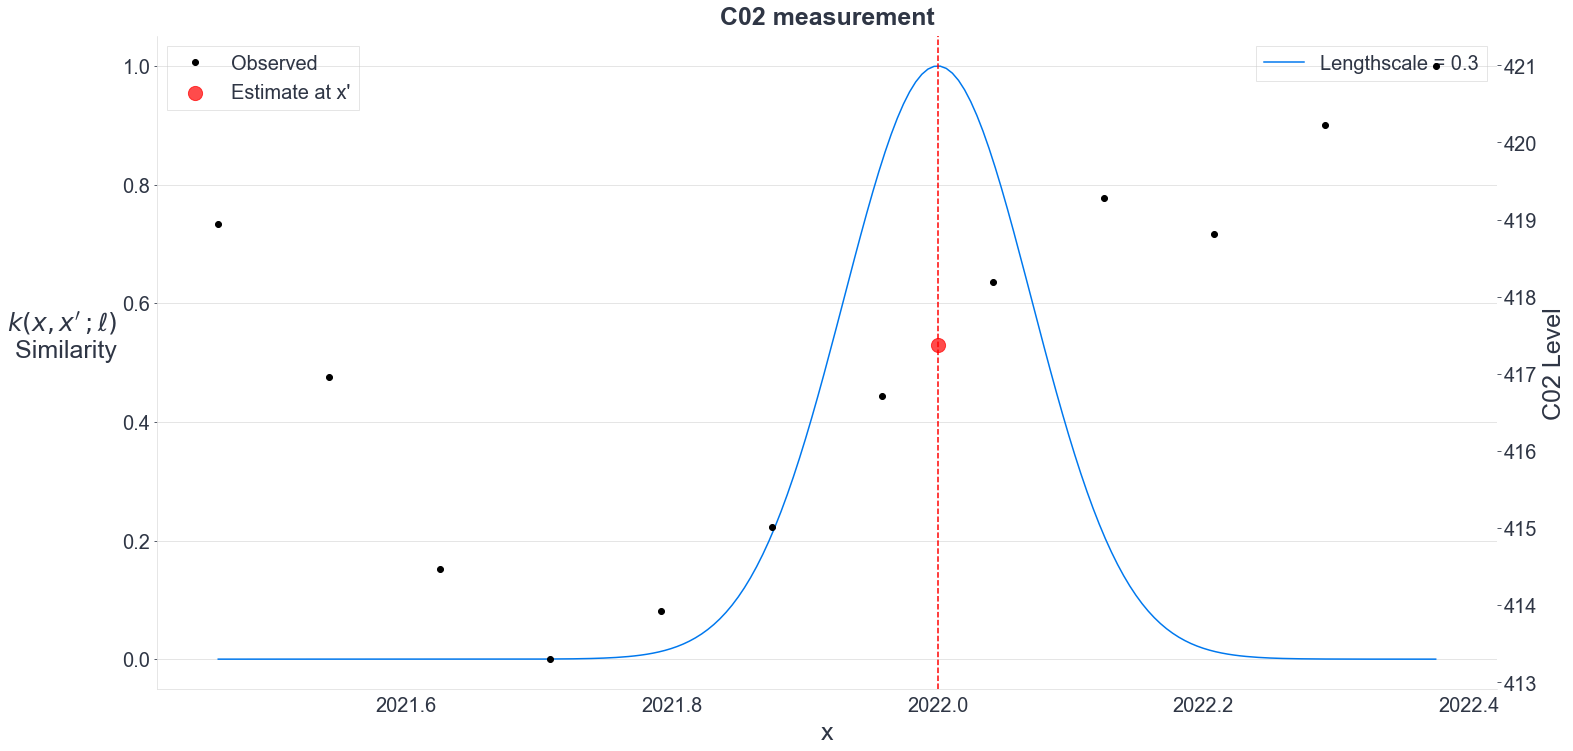

In [26]:
fig = plt.figure(figsize=figsize)

plt.plot(x, kernel(x, x_prime, lengthscale), label=f"Lengthscale = {ell}");
## plot vertical line at x_prime = 2022.0
plt.axvline(x=x_prime, color="r", linestyle="--")
ax.annotate("x'", xy=(2022, 414),  xycoords='data',
    xytext=(0.68, 0.27), textcoords='axes fraction', 
    arrowprops=dict(facecolor='black'), fontsize=30,
    horizontalalignment='right', verticalalignment='top',
);
plt.legend(fontsize=20, frameon=True);

## labels
plt.ylabel("$k(x, x'\,; \ell)$\n Similarity", rotation=0, loc="center", labelpad= 60);
plt.xlabel("x");

## overlay real data, new scale
ax = plt.gca()
ax2 = ax.twinx()
ax2 = plot_data(ax2)
ax2.grid(False);

## calculate estimate and plot it
estimate = kernel_machine(
    last_12_obs["decimal date"].values, 
    last_12_obs["average"].values, 
    x_prime, 
    lengthscale,
)
ax2.scatter([x_prime], [estimate], color="r", marker="o", s=200, label="Estimate at x'", alpha=0.7);

plt.legend(fontsize=20, frameon=True);

Looks pretty good!  Now lets drop the plot of the kernel function itself, and look at the fit the kernel machine gives at many $x'$ values across the domain.

## Making C02 estimates for *every* x

''

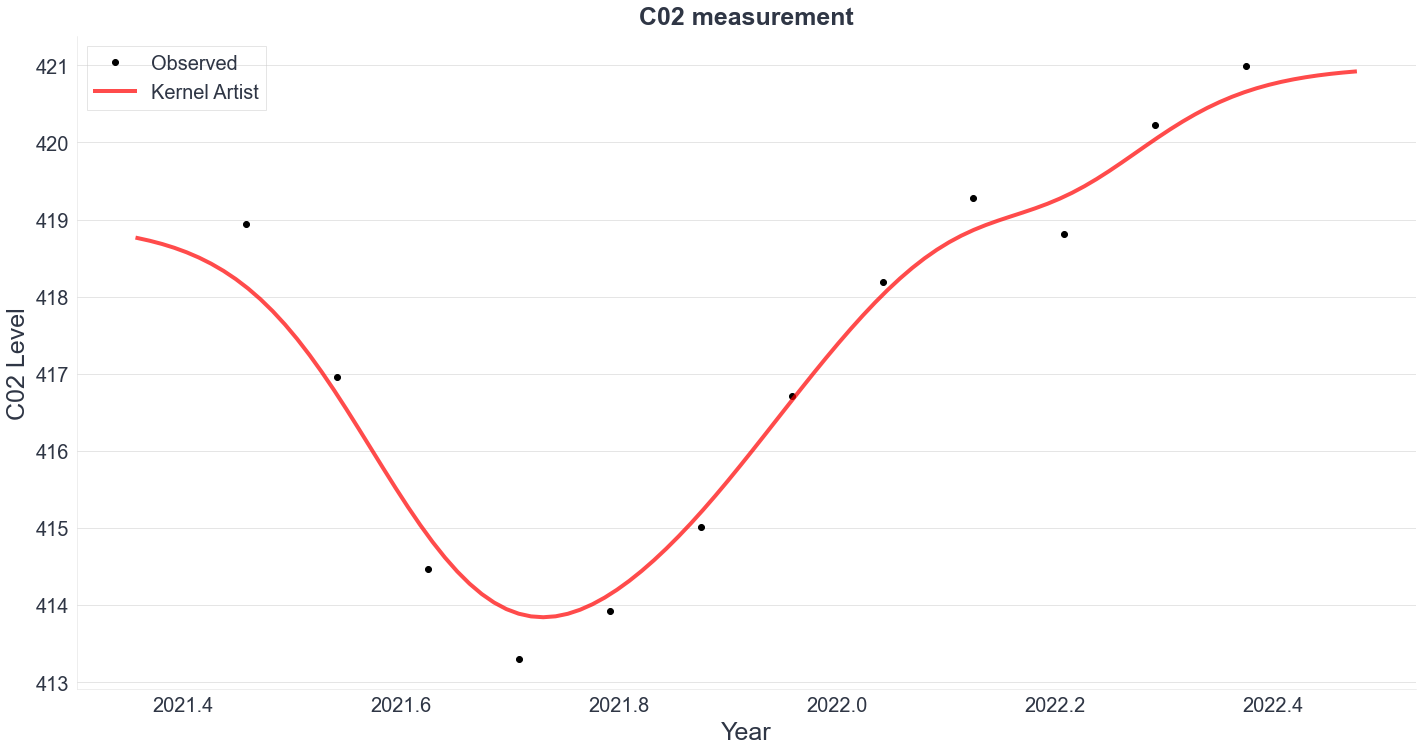

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plot_data(ax)

lengthscale = 0.1

x_range = np.linspace(last_12_obs["decimal date"].min() - 0.1, last_12_obs["decimal date"].max() + 0.1, 100)
estimates = []
for x_prime in x_range:
    estimates.append(kernel_machine(
        last_12_obs["decimal date"].values, 
        last_12_obs["average"].values, 
        x_prime, 
        lengthscale,
    ))
    
ax.plot(x_range, estimates, color="r", alpha=0.7, lw=4, label="Kernel Artist")
plt.legend(fontsize=20, frameon=True);

Much better!  This is clearly the best fit we've been able make so far, whether we are using specific functional forms, or nearest neighbors.  This still isn't a Gaussian process though (the full, stochastic, Jackson Pollock)!  Maybe right now, we kind of know how to make the brush strokes, but not the full picture.  Still, this is an important milestone.

Kernels are a **really, really** important concept in machine learning and statistics.  So much theory is built on them.  It's really a much larger and broader topic than Gaussian processes themselves!  All the intuition we've picked up here, applies just as well to any kernel-based method as it does to GPs.  There are also many, many other fascinating kernels out there -- each describing some other notion of similarity, that allows us to build really effective models.  We'll learn a lot more about them too later in the course. 


## What are we missing?


- This is Intuitive Bayes, so, where's the Bayes??  
  - Are GPs Bayesian?
- The estimates look good, but we have no sense of uncertainty! 
  - What is the range of "viable fit lines" here?
- How do we choose the lengthscale?  
  - Can we put prior on it?
- This is a simple time series...
  - what other types of data can we model?


While this does take us most of the way, we still have a few questions to answer before we have a full GP.  The kernel is one of the major parts.  The other is the multivariate normal probability distribution.  We'll learn about that in the next section.  Putting these two concepts together gives us the Gaussian process.  
What questions are left then?  In later lessons, we'll learn more about

## Section Recap
**This is just a proposal for now**

* Took our nearest neighbors function and added the idea of distance
* The distance from our x', point of interest, to the observed x defines their weight
* Can control the effect of distance with length scale
  * Larger length scales compress the distance
* Built a function that estimates the y C02 value at every x'


## The full GP

This may seem like a lot of moving pieces, but taken together, the result is simple and I think, pretty elegant, and very useful.  In PyMC, coding up a non-trivial GP model for the complete Mauna Loa data looks like this:

In [251]:
## Prepare data
x = data["decimal date"].values - data["decimal date"].min()

y_mu = data["average"].mean()
y_sd = data["average"].std()
y = (data["average"].values - y_mu) / y_sd

y = data["average"].values

In [307]:
## Make a new kernel!
class RandomWalk(pm.gp.cov.Covariance):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])

    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        return at.minimum(X, at.transpose(Xs)) 

    def diag(self, X):
        return at.reshape(X, (-1, ))

In [332]:
## PyMC model

coords = {'time': subset['decimal date'].values}
with pm.Model(coords=coords) as model:
    
    # annual periodic component that decays over time
    eta_per = pm.HalfNormal("eta_per", sigma=10)
    ell_pdecay = pm.Gamma("ell_pdecay", alpha=10, beta=0.075)
    ell_psmooth = pm.Gamma("ell_psmooth ", alpha=4, beta=3)
    period = 1.0 # annual cycles
    cov_seasonal = (
        eta_per**2 * pm.gp.cov.Periodic(1, period, ell_psmooth) * pm.gp.cov.ExpQuad(1, ell_pdecay)
    )
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    eta_med = pm.HalfNormal("eta_med", sigma=10.0)
    ell_med = pm.Gamma("ell_med", alpha=2, beta=0.5)
    cov_medium = eta_med ** 2 * pm.gp.cov.Matern32(1, ell_med)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    eta_trend = pm.HalfNormal("eta_trend", sigma=50.0)
    ell_trend = pm.Gamma("ell_trend", alpha=12.0, beta=0.1)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ell_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)
    
    # short term random walk
    eta_rw = pm.HalfNormal("eta_rw", sigma=1.0)
    cov_rw = eta_rw**2 * RandomWalk()
    gp_rw = pm.gp.Marginal(cov_func=cov_rw)
    
    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_trend + gp_medium + gp_rw 

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    likelihood = gp.marginal_likelihood("likelihood", X=x[:, None], y=y, noise=sigma, dims="time")

In [333]:
## Inference using ADVI

with model:
    mean_field = pm.fit(
        method="advi", 
        callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")],
        obj_optimizer=pm.adamax(learning_rate=0.1),
    )

Interrupted at 1,665 [16%]: Average Loss = 245.66


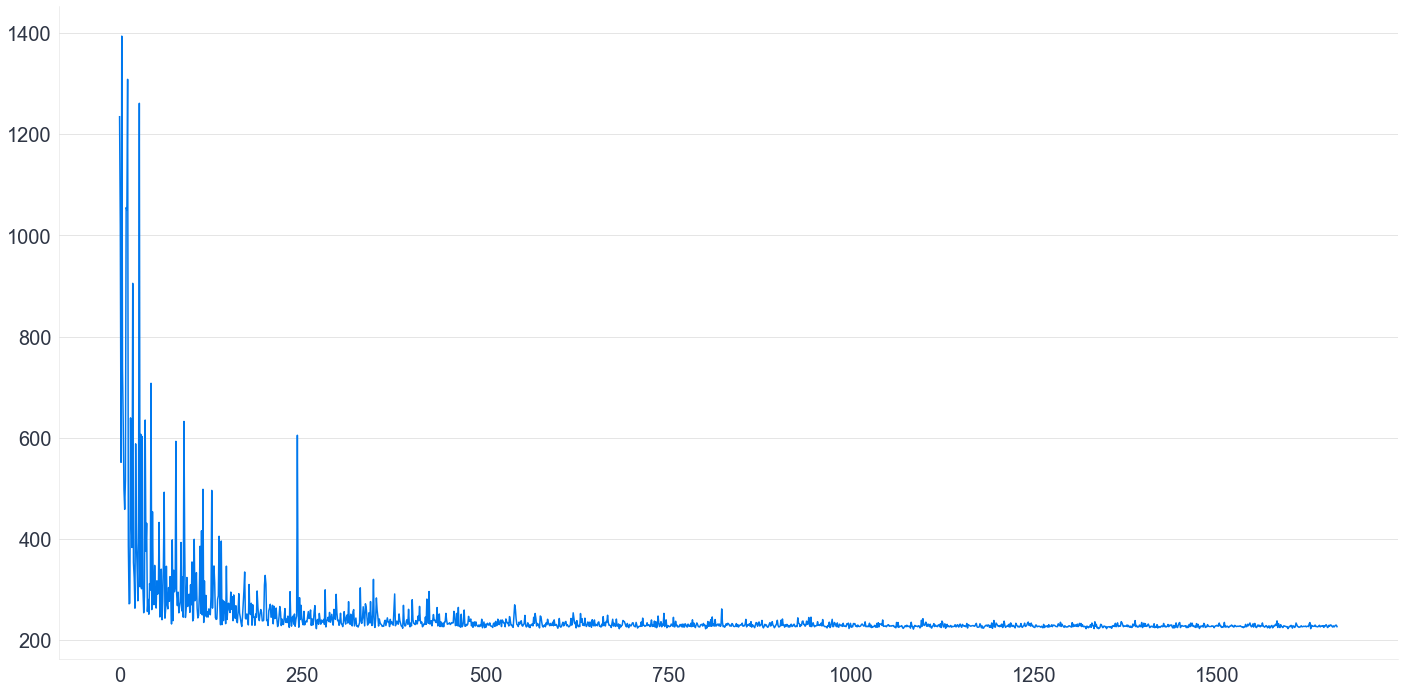

In [334]:
plt.figure(figsize=figsize)
plt.plot(mean_field.hist);

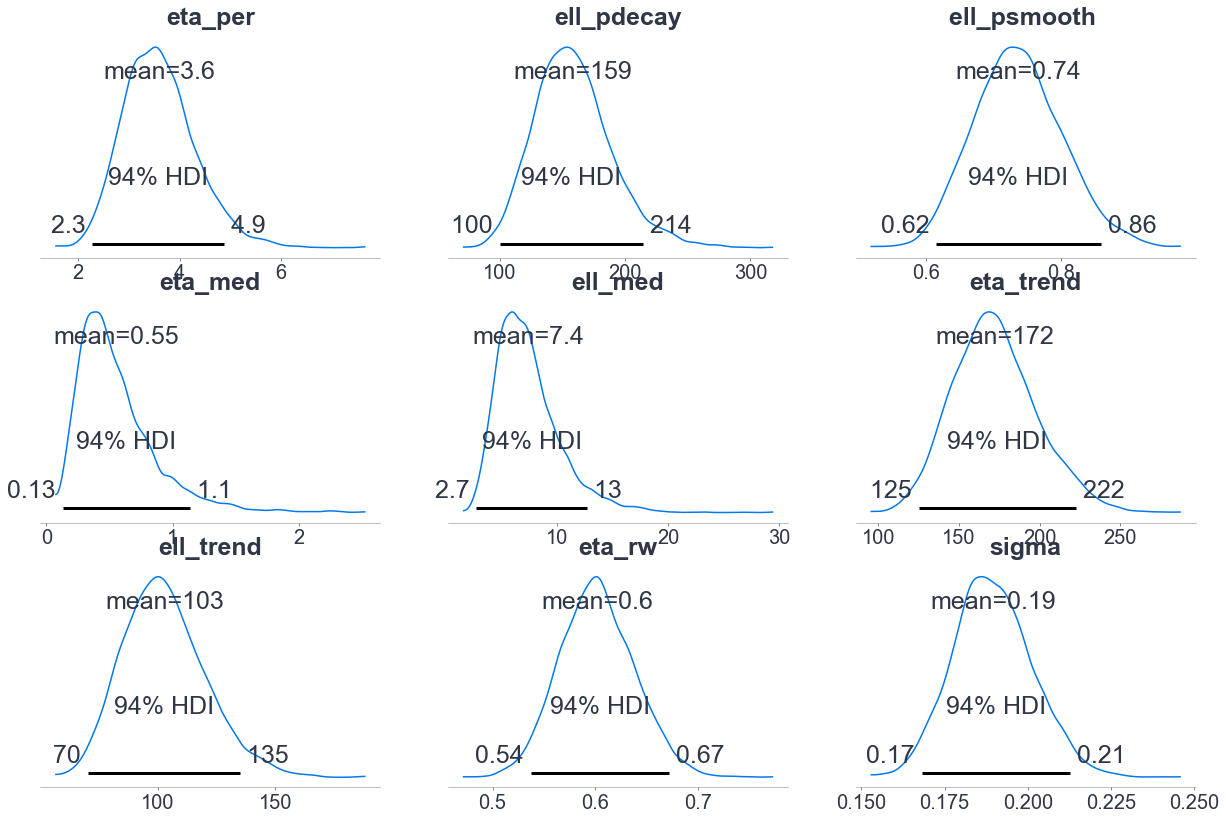

In [338]:
idata = mean_field.sample(5000)
az.plot_posterior(idata);

In [336]:
## Generate fit and forecast

xnew = np.linspace(2000, 2040, 300)
xnew = xnew - subset["decimal date"].min()
with model:
    f = gp.conditional('f', Xnew=xnew[:, None])
    ppc = pm.sample_posterior_predictive(idata, samples=500, var_names=['f'], return_inferencedata=False)

/var/folders/ph/dzn92qs11xxgr9vnqs2mt2z40000gq/T/ipykernel_52986/70176128.py:7: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  ppc = pm.sample_posterior_predictive(idata, samples=500, var_names=['f'], return_inferencedata=False)


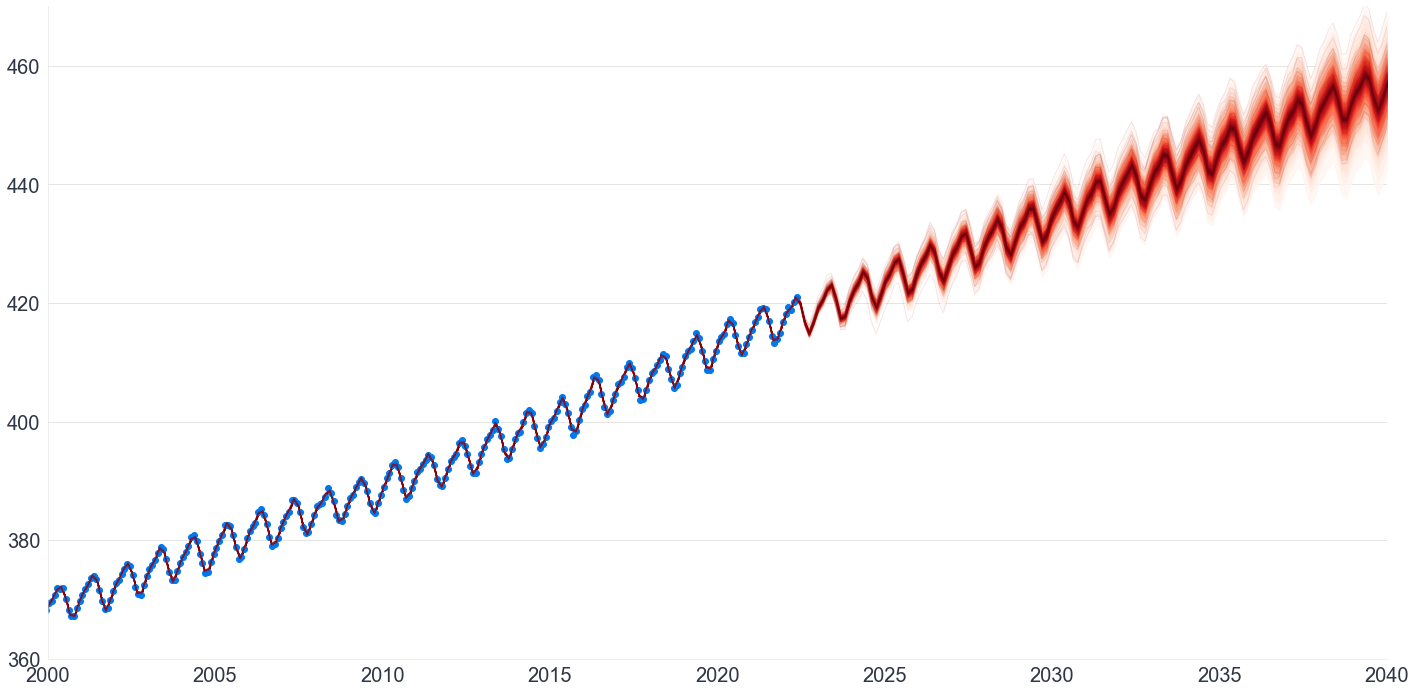

In [341]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
plt.plot(subset['decimal date'], subset['average'], 'o');

pm.gp.util.plot_gp_dist(ax, ppc['f'], xnew + subset["decimal date"].min());

plt.xlim([2000, 2040]);
plt.ylim([360, 470]);

In [342]:
## Calculate the MAP (maximum a-posteriori) point from our ADVI fit 
mp = {name: float(val) for name, val in dict(idata.posterior.mean()).items()}

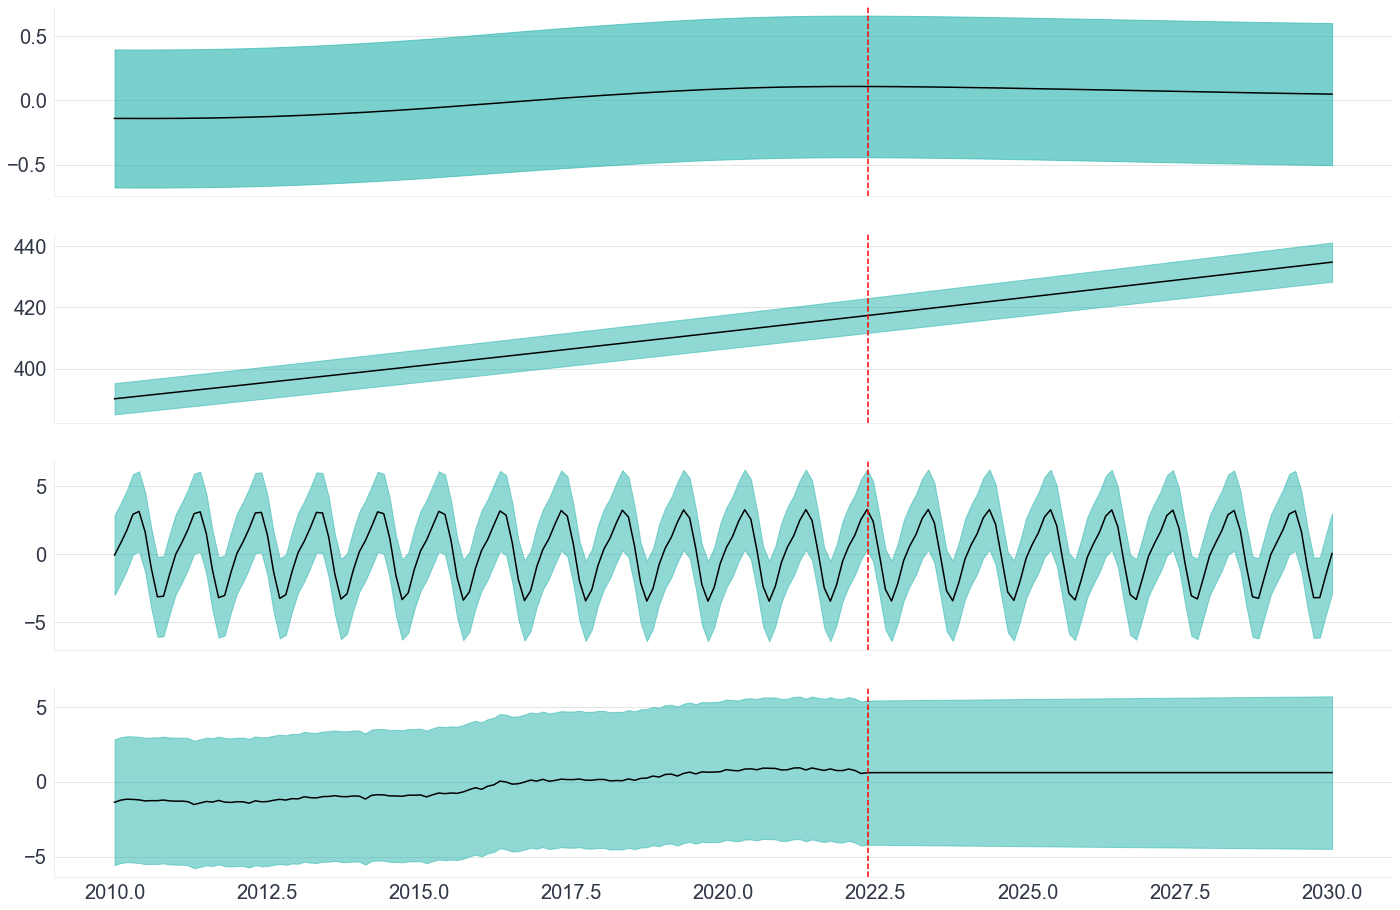

In [343]:
## Plot the three components (keep this?)

fig, axs = plt.subplots(4, 1, figsize=(24, 16), sharex=True)
axs = axs.flatten()

xnew = np.linspace(2010, 2030, 200)
xnew = xnew - subset["decimal date"].min()
with model:
    mu, var = gp_medium.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[0].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.6);
    axs[0].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[0].axvline(x=data["decimal date"].max(), color="r", linestyle="--");

with model:
    mu, var = gp_trend.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[1].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.5);
    axs[1].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[1].axvline(x=data["decimal date"].max(), color="r", linestyle="--");
    
with model:
    mu, var = gp_seasonal.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[2].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.5);
    axs[2].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[2].axvline(x=data["decimal date"].max(), color="r", linestyle="--");

with model:
    mu, var = gp_rw.predict(
        xnew[:, None], point=mp, given={"gp": gp, "X": x[:, None], "y": y, "noise": cov_noise}, diag=True
    )
    axs[3].fill_between(xnew + subset["decimal date"].min(), mu - np.sqrt(var), mu + np.sqrt(var), color="LightSeaGreen", alpha=0.5);
    axs[3].plot(xnew + subset["decimal date"].min(), mu, color='k')
    axs[3].axvline(x=data["decimal date"].max(), color="r", linestyle="--");